In [1]:
import torch
import numpy as np
import pandas as pd
import argparse
from module.StructureEncoder import StructureDataEncoder
import mantel
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from joblib import Parallel, delayed

D:\Anaconda3\envs\Image-Text\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_args():
    parser = argparse.ArgumentParser(description="AI Triage")
    parser.add_argument("--data_path", default=r"./data/AllRightData.txt")
    args = parser.parse_args(args = [])
    return args

In [3]:
args = get_args()
RawData = pd.read_csv(args.data_path, engine='python')
data = pd.DataFrame(RawData, columns=['性别','出生日期','分诊时间','到院方式',
                                      '分诊印象','T℃', 'P(次/分)', 'R(次/分)', 'BP(mmHg)', 'SpO2', 
                                      '级别','去向'])

In [4]:
def Structure(data):
    digit = StructureDataEncoder()
    ar = data['到院方式'].apply(lambda x: digit.Arr_way(x)).values
    g  = data['性别'].apply(lambda x: digit.Gender(x)).values
    a  = data['出生日期'].apply(lambda x: digit.Age(x)).values
    t  = data['T℃'].apply(lambda x: digit.Temperature(x)).values
    p  = data['P(次/分)'].apply(lambda x: digit.Pulse(x)).values
    r  = data['R(次/分)'].apply(lambda x: digit.Respiration(x)).values
    bp = data['BP(mmHg)'].apply(lambda x: digit.BloodPressure(x)).values
    s  = data['SpO2'].apply(lambda x: digit.SpO2(x)).values
    return ar, g, a, t, p, r, bp, s

In [5]:
Length = 100000000
data.replace('空值', np.nan, inplace=True)
# 剔除包含4个及以上空值的样本
# data1 = data.dropna(thresh=data.shape[1] - 2 + 1)  # 保留至少有 (列总数 - 4 + 1) 个非空值的样本
data = data.dropna()
# data1.replace(np.nan, '空值', inplace=True)
a = Structure(data[:Length])
b = torch.tensor(a).t()

C:\Users\user\AppData\Local\Temp\ipykernel_13632\533597526.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:277.)
  b = torch.tensor(a).t()


In [6]:
unique_levels = data['级别'][:Length].dropna().unique()  #去除缺失值并获取唯一值
unique_departments = data['去向'][:Length].dropna().unique()
dic1 = {level: idx for idx, level in enumerate(unique_levels)}
dic2 = {dept: idx for idx, dept in enumerate(unique_departments)}
Y1 = torch.tensor(data[:Length]['级别'].map(dic1).fillna(-1).astype(int).values).long()
Y2 = torch.tensor(data[:Length]['去向'].map(dic2).fillna(-1).astype(int).values).long()

In [7]:
env_variables =  ['MOA','sex', 'age', 'temp', 'pulse', 'resp', 'bp', 'spo2']
env_data = pd.DataFrame(b, columns=env_variables)

labels = torch.stack([Y1, Y2])

species = ['SLP','DR']
species_data = pd.DataFrame(labels.t(), columns=species) 
combined_data = pd.concat([env_data, species_data], axis=1)
combined_data

,MOA,sex,age,temp,pulse,resp,bp,spo2,SLP,DR
0,2,1,1,1,1,1,1,1,0,0
1,1,2,1,2,1,1,0,1,1,0
2,3,1,3,1,1,2,1,1,0,1
3,0,2,3,1,1,1,0,2,0,0
4,2,1,1,1,2,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
82,1,1,1,2,1,2,4,1,1,0
83,3,1,1,1,1,2,0,1,0,0
84,1,1,2,1,2,1,0,1,1,0
85,1,1,3,1,1,1,1,1,2,0


Analyzing Severity=0, 19 samples


D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


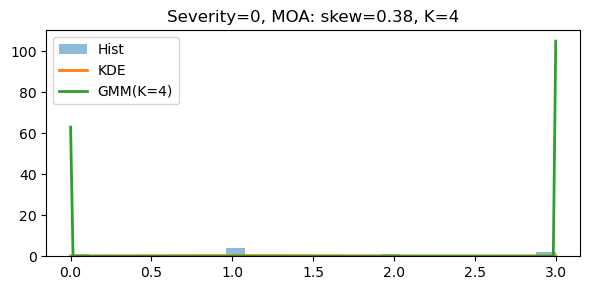

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

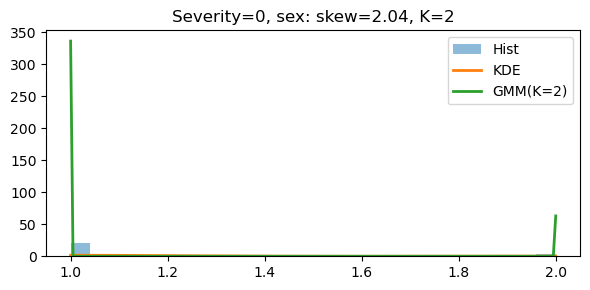

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


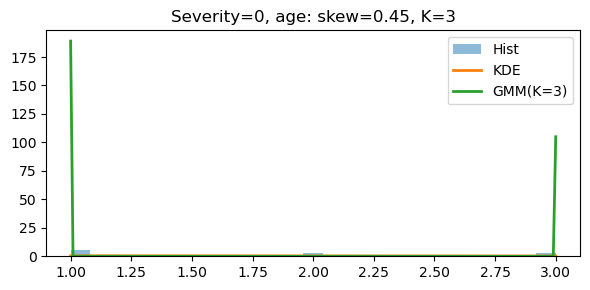

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

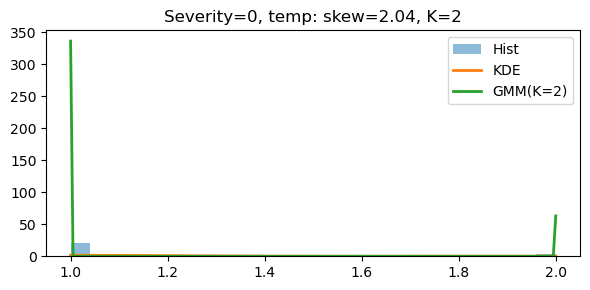

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

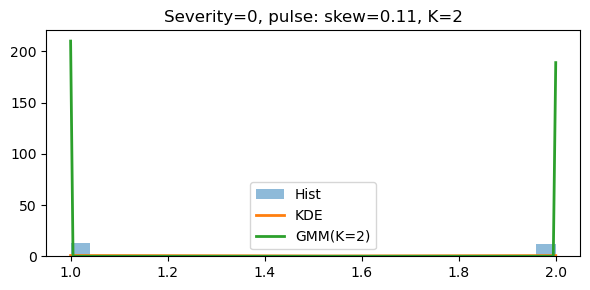

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

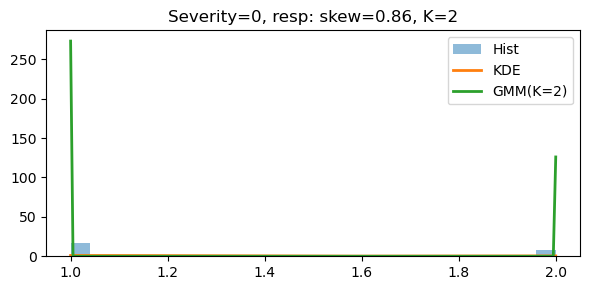

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


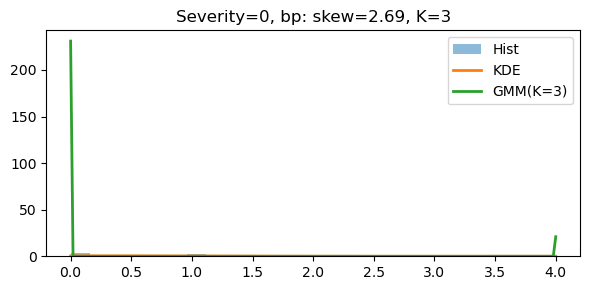

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

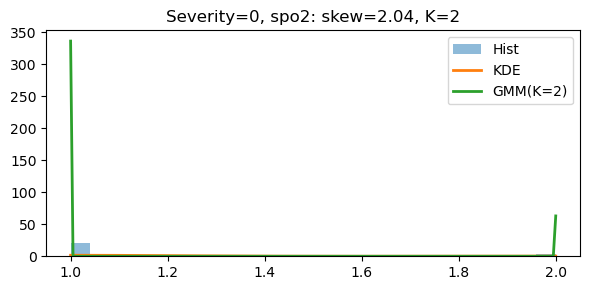

Analyzing Severity=1, 24 samples


D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


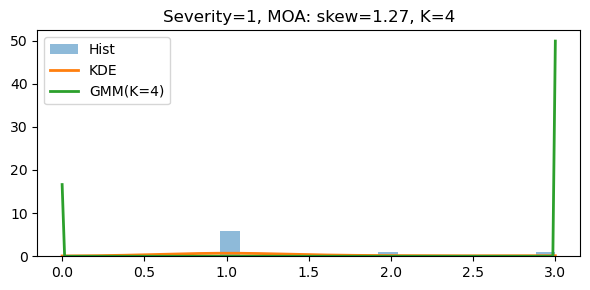

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

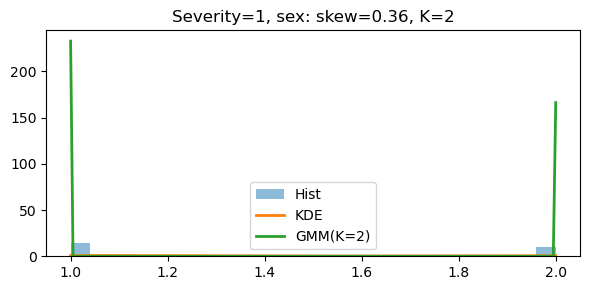

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


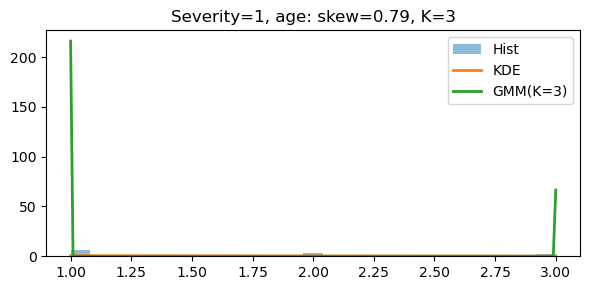

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

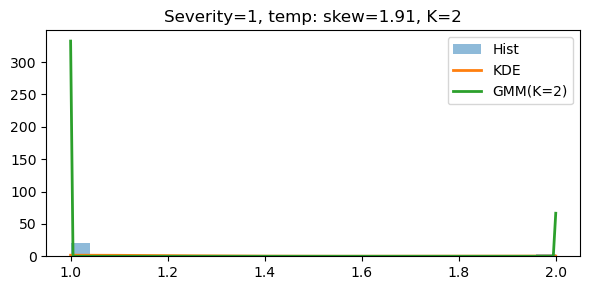

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

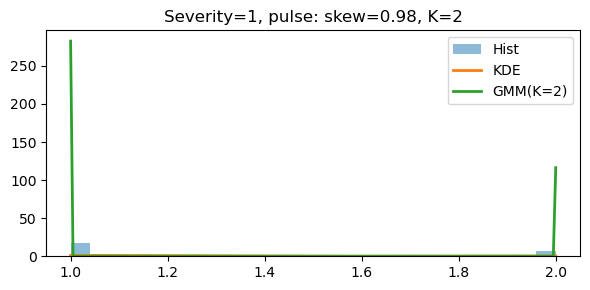

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

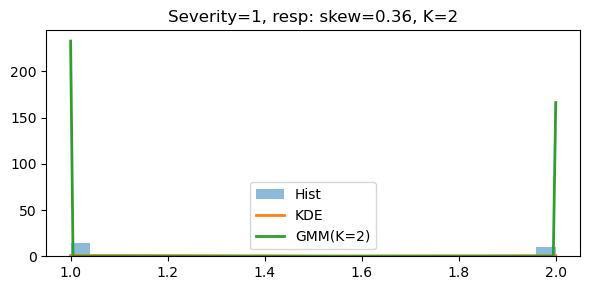

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


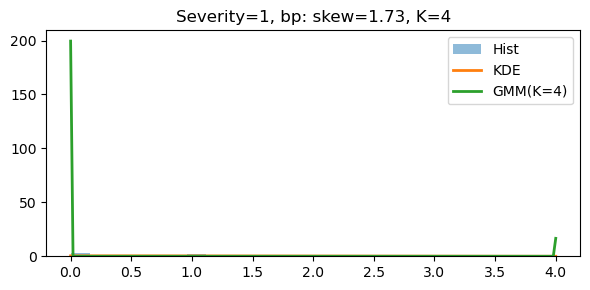

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

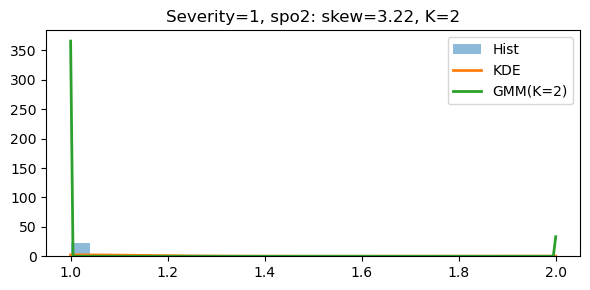

Analyzing Severity=2, 38 samples


D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


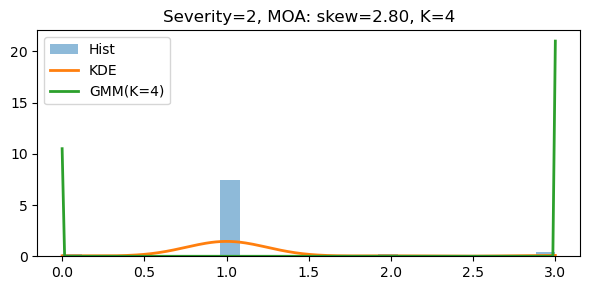

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

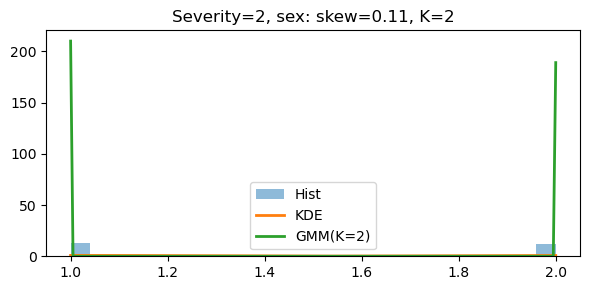

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


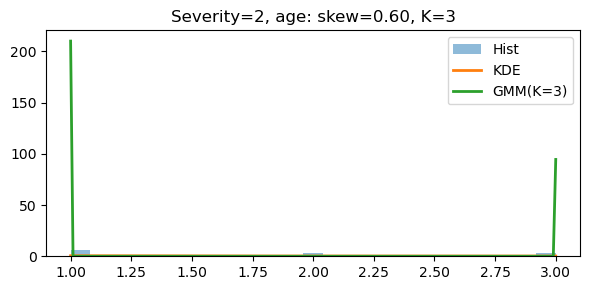

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

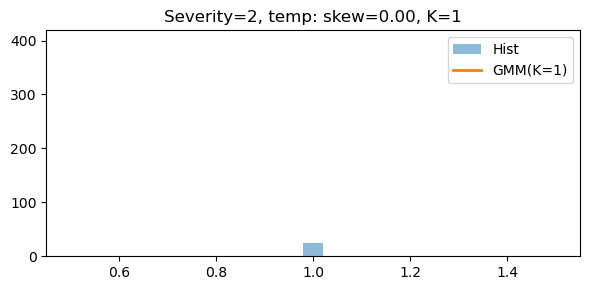

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

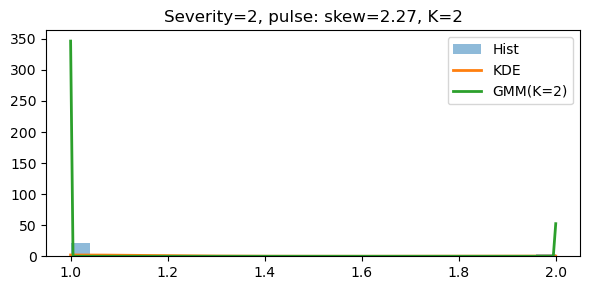

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

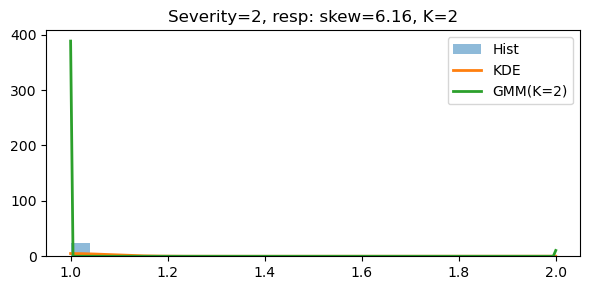

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


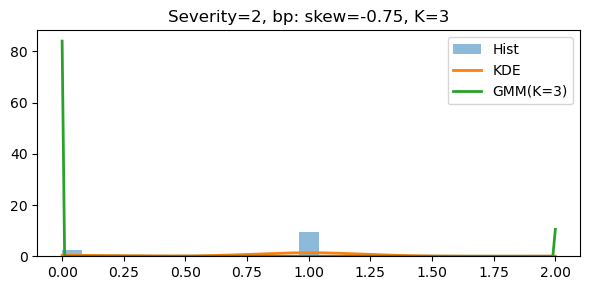

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

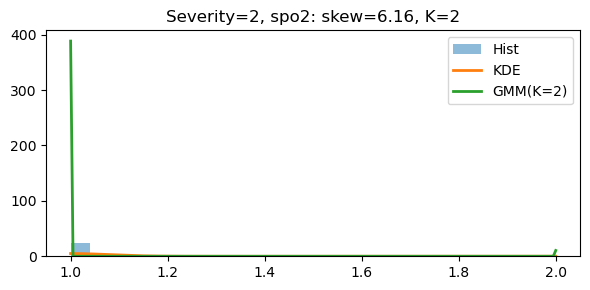

Analyzing Severity=3, 6 samples


D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

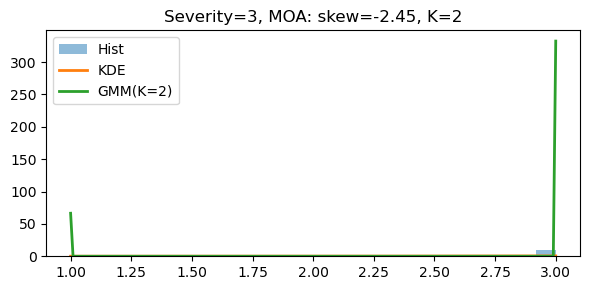

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

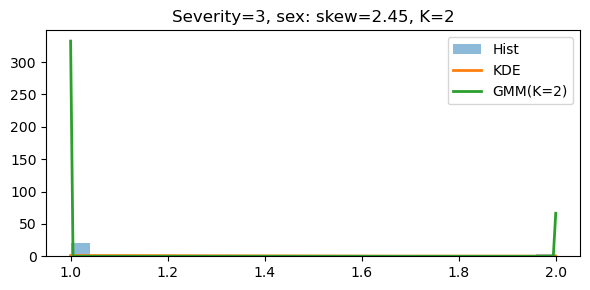

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

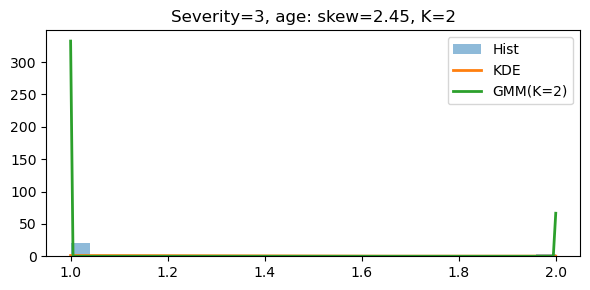

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

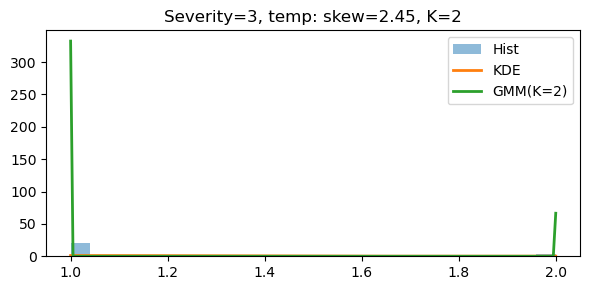

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

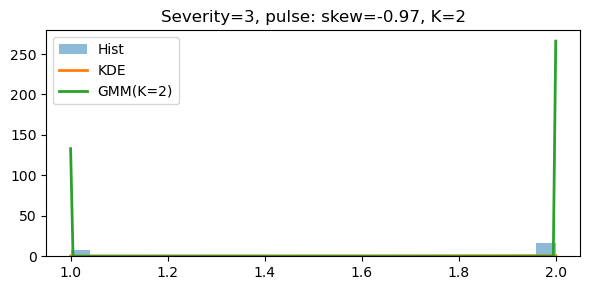

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

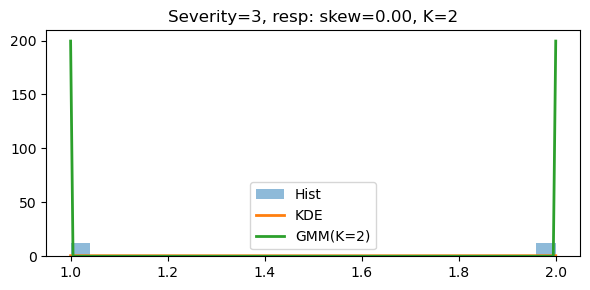

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


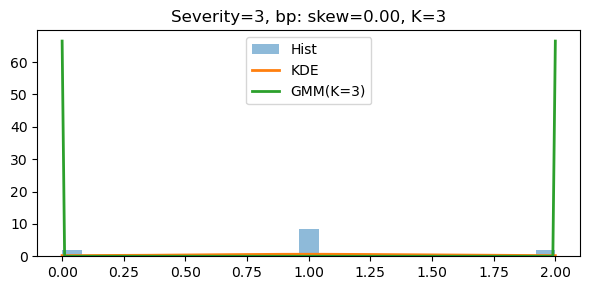

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

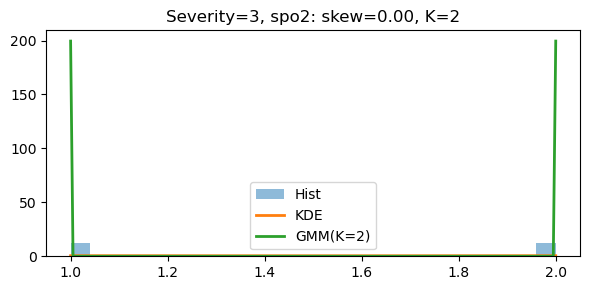

Analyzing Department=0, 68 samples


D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


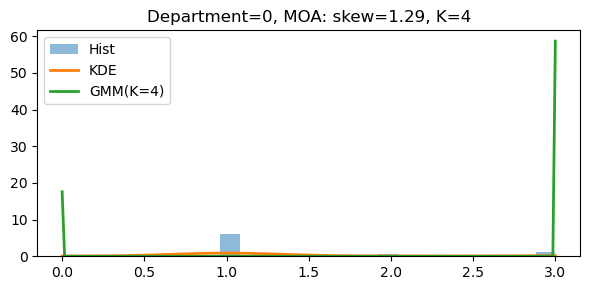

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

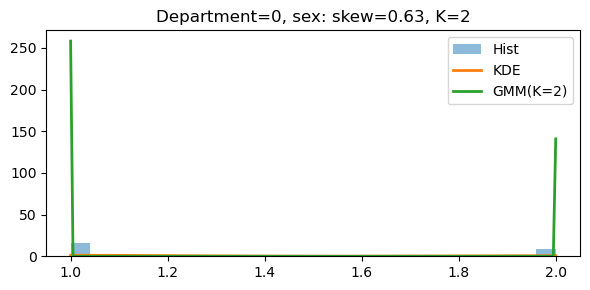

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


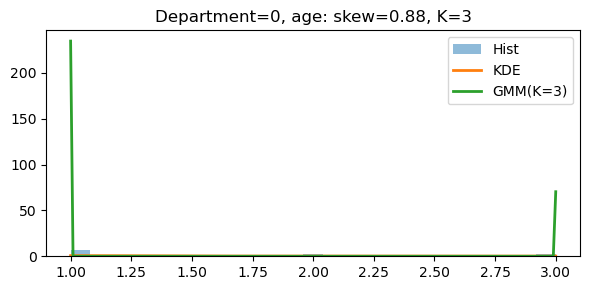

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

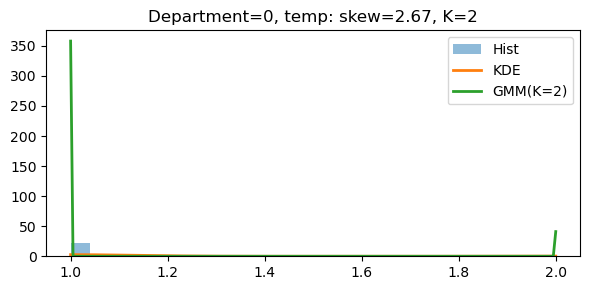

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

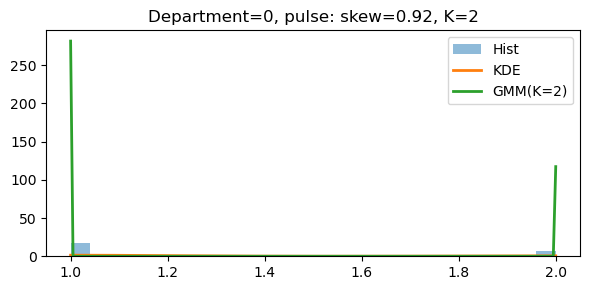

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

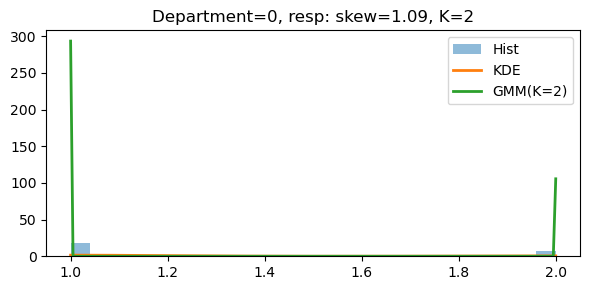

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


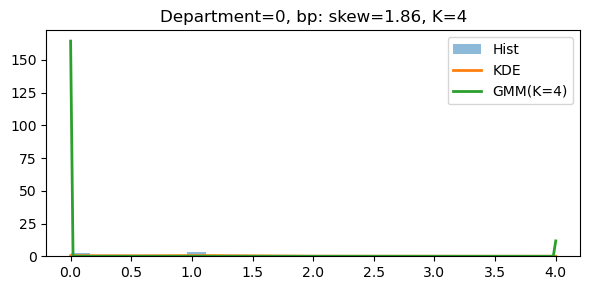

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

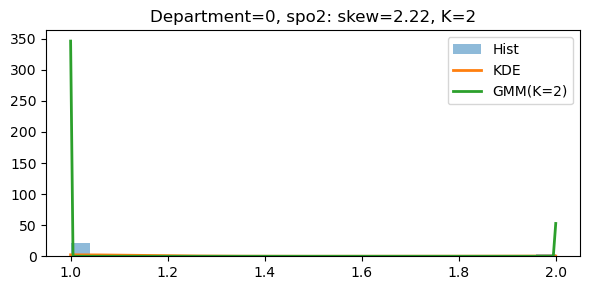

Analyzing Department=1, 13 samples


D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


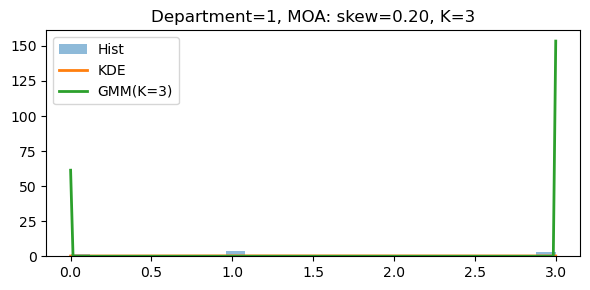

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

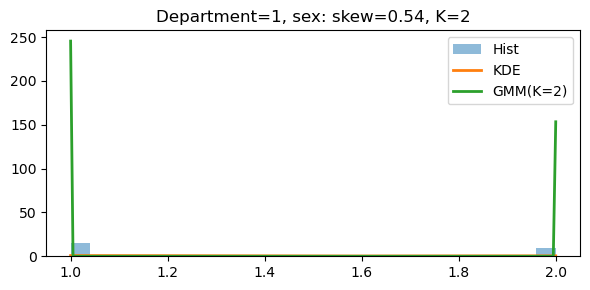

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  cluster.KMeans(


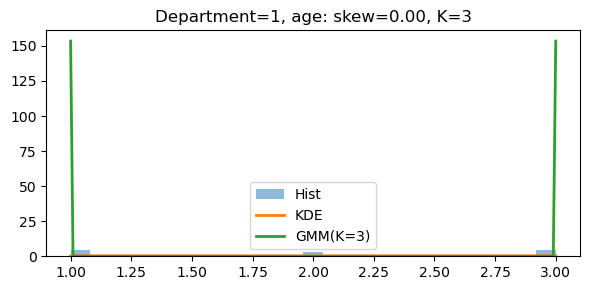

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

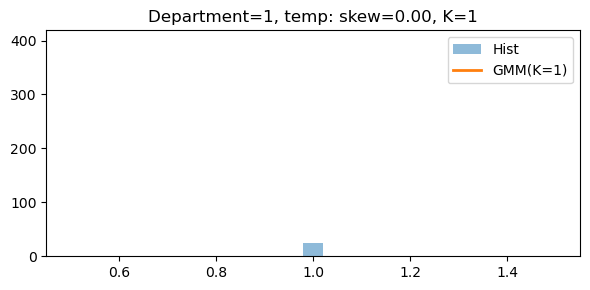

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

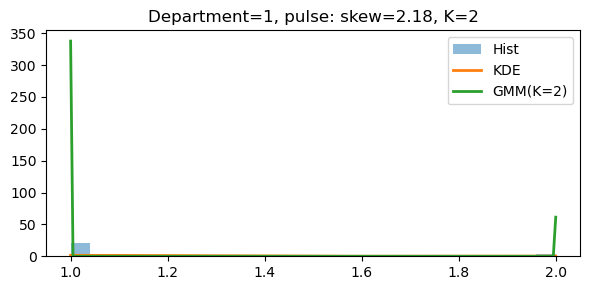

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

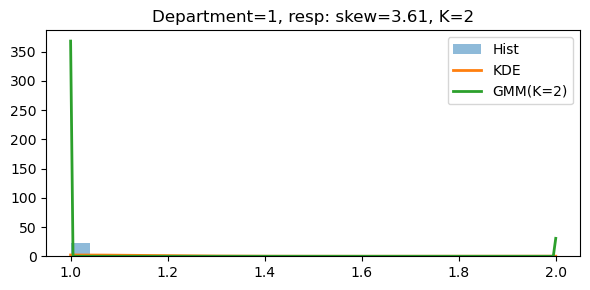

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

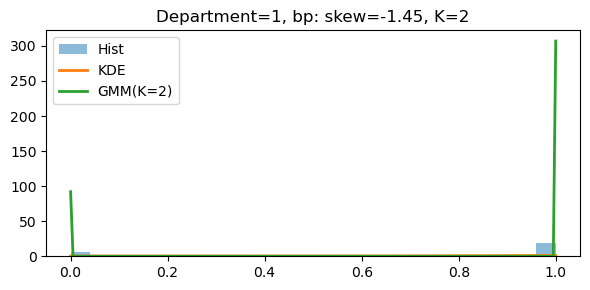

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

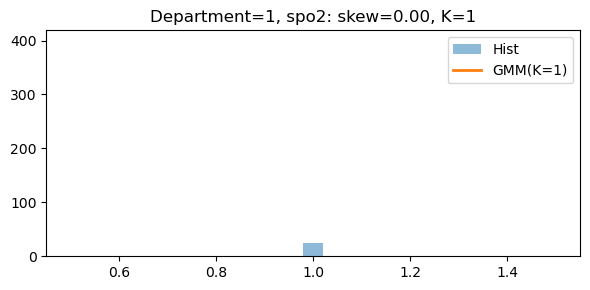

Analyzing Department=2, 5 samples


D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

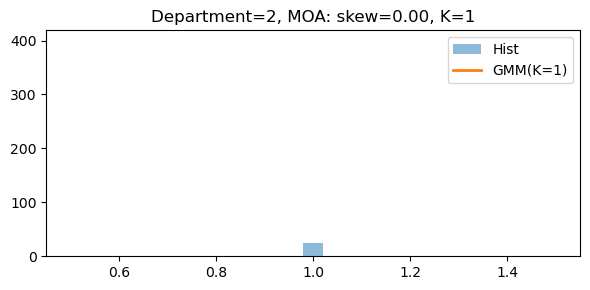

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(


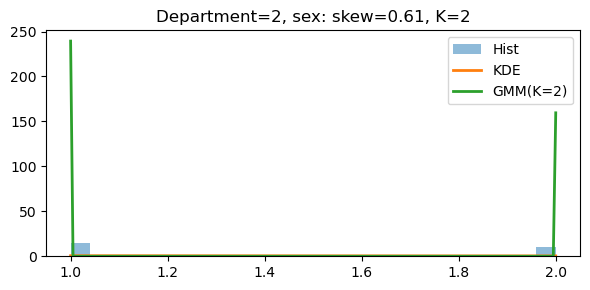

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(


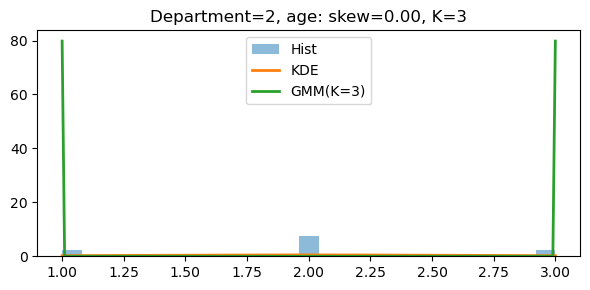

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(


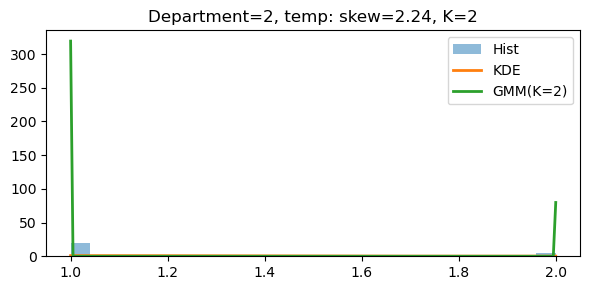

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(


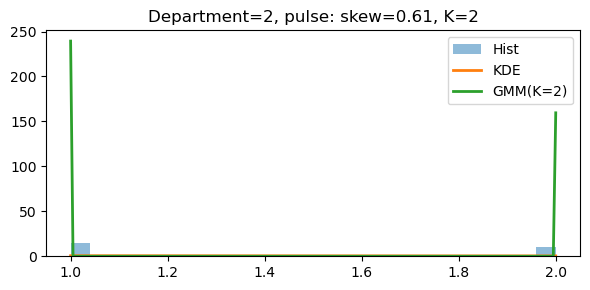

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(


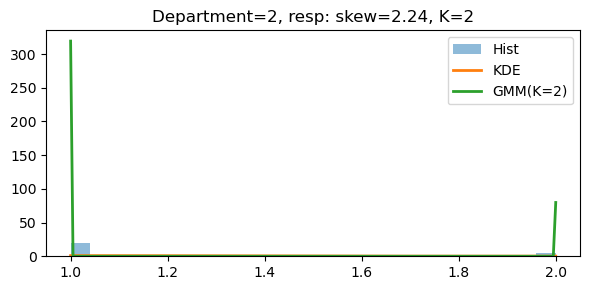

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  cluster.KMeans(


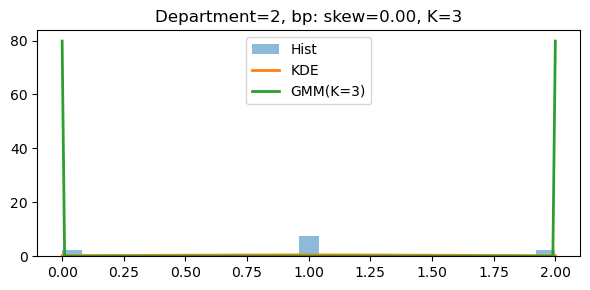

D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-packages\sklearn\mixture\_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  cluster.KMeans(
D:\Anaconda3\envs\Image-Text\lib\site-package

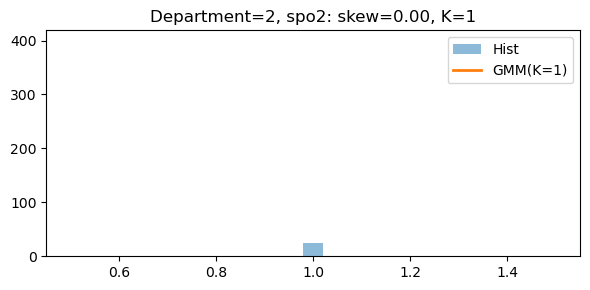

Analyzing Department=3, 1 samples
  Skipping MOA due to insufficient samples (1)
  Skipping sex due to insufficient samples (1)
  Skipping age due to insufficient samples (1)
  Skipping temp due to insufficient samples (1)
  Skipping pulse due to insufficient samples (1)
  Skipping resp due to insufficient samples (1)
  Skipping bp due to insufficient samples (1)
  Skipping spo2 due to insufficient samples (1)


In [16]:
'''
按任务（Severity 和 Department）分别分析生命体征分布，并保存结果，带偏度与 GMM 分析。脚本步骤：
1. 导入数据与库
2. 定义 GMM 拟合函数（自动调整成分上限为样本数）
3. 循环任务（SLP、DR）下每个类别：
   - 计算偏度
   - 拟合 GMM，获取最优组件数
   - 绘制直方图，条件绘制 KDE，叠加 GMM 密度曲线
4. 汇总 `task, class, feature, skewness, optimal_gmm_components` 并保存为 CSV

注意：GMM 的成分数上限不超过样本数量，避免 `n_samples < n_components` 错误。
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy import stats

# 1. 准备数据
df = combined_data.copy()
vital_cols = ['MOA','sex','age', 'temp', 'pulse', 'resp', 'bp', 'spo2']
tasks = {'SLP': 'Severity', 'DR': 'Department'}

# 2. 定义 GMM 拟合函数
def fit_gmm(x, max_components=6, random_state=0):
    arr = x.dropna().values.reshape(-1,1)
    n_samples = arr.shape[0]
    max_k = min(max_components, n_samples)
    if n_samples < 1:
        raise ValueError('No data')
    bics, models = [], []
    for k in range(1, max_k+1):
        gm = GaussianMixture(n_components=k, covariance_type='full', random_state=random_state)
        gm.fit(arr)
        bics.append(gm.bic(arr))
        models.append(gm)
    best_idx = int(np.argmin(bics))
    return models[best_idx]

# 3. 分析循环
results = []
for task_col, task_name in tasks.items():
    for cls in sorted(df[task_col].dropna().unique()):
        sub = df[df[task_col] == cls]
        print(f"Analyzing {task_name}={cls}, {len(sub)} samples")
        for col in vital_cols:
            x = sub[col].dropna()
            if len(x) < 2:
                print(f"  Skipping {col} due to insufficient samples ({len(x)})")
                continue
            # 3.1 计算偏度
            skew = x.skew()
            # 3.2 GMM 拟合
            gm = fit_gmm(x)
            k_opt = gm.n_components
            # 3.3 绘图
            plt.figure(figsize=(6,3))
            plt.hist(x, bins=25, density=True, alpha=0.5, label='Hist')
            xs = np.linspace(x.min(), x.max(), 200)
            # KDE if possible
            if x.nunique() > 1 and len(x) > 1:
                try:
                    kde = stats.gaussian_kde(x)
                    plt.plot(xs, kde(xs), lw=2, label='KDE')
                except Exception:
                    pass
            # GMM 密度
            logprob = gm.score_samples(xs.reshape(-1,1))
            plt.plot(xs, np.exp(logprob), lw=2, label=f'GMM(K={k_opt})')
            plt.title(f"{task_name}={cls}, {col}: skew={skew:.2f}, K={k_opt}")
            plt.legend(loc='best')
            plt.tight_layout()
            plt.show()
            # 3.4 记录
            results.append({
                'task': task_name,
                'class': cls,
                'feature': col,
                'skewness': skew,
                'optimal_gmm_components': k_opt
            })

# 4. 保存结果
results_df = pd.DataFrame(results)
results_df.to_csv('vital_signs_by_task_gmm_analysis2.csv', index=False)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化存储p值和相关系数的DataFrame
p_values_df = pd.DataFrame(index=env_variables, columns=species)
r_values_df = pd.DataFrame(index=env_variables, columns=species)

# 将数据转换为torch tensor并移动到GPU
combined_data_tensor = torch.tensor(combined_data.values, dtype=torch.float32).to(device)

# 预计算环境变量的距离矩阵
def compute_distance_matrix(data_tensor):
    # 计算欧几里得距离矩阵
    dist_matrix = torch.cdist(data_tensor, data_tensor, p=2)  # 使用cdist计算距离
    return dist_matrix

# 预计算环境变量的距离矩阵
env_distance_matrices = {
    env_var: compute_distance_matrix(combined_data_tensor[:, i:i+1])  # 针对每个环境变量计算
    for i, env_var in enumerate(env_variables)
}

# 预计算物种的距离矩阵
species_distance_matrices = {
    spec: compute_distance_matrix(combined_data_tensor[:, i:i+1])  # 针对每个物种计算
    for i, spec in enumerate(species)
}

# Mantel检验的计算函数
def compute_mantel(env_var, spec):
    # 获取环境变量和物种的距离矩阵
    env_distance_matrix = env_distance_matrices[env_var].cpu().numpy()  # 转回CPU并转为numpy
    species_distance_matrix = species_distance_matrices[spec].cpu().numpy()

    # Mantel检验，减少perms次数以提升性能
    mantel_stat, p_value, _ = mantel.test(env_distance_matrix, species_distance_matrix, perms=100000, method='pearson')
    
    return env_var, spec, mantel_stat, p_value

# 并行计算Mantel检验
results = Parallel(n_jobs=-1)(delayed(compute_mantel)(env_var, spec) for env_var in env_variables for spec in species)

# 将结果存储到DataFrame
for env_var, spec, mantel_stat, p_value in results:
    p_values_df.loc[env_var, spec] = p_value
    r_values_df.loc[env_var, spec] = mantel_stat

# 输出p值DataFrame
p_values_df

,SLP,DR
MOA,0.00001,0.9589
sex,0.234588,0.00001
age,0.03116,0.00832
temp,0.01238,0.888571
pulse,0.937001,0.98362
resp,0.00001,0.96423
bp,0.00009,0.195938
spo2,0.00518,0.664473


In [19]:
G = nx.Graph()
G.add_nodes_from(p_values_df.columns)  # 添加spec列作为节点
G.add_nodes_from(p_values_df.index)    # 添加index作为节点
# 预定义颜色、透明度和边宽度的映射
color_alpha_map = {
    (0, 0.001): ('steelblue', 0.9),  # 淡绿色，接近不透明
    (0.001, 0.01): ('lightsteelblue', 0.7),  # 淡紫色，半透明
    (0.01, 0.05): ('lightblue', 0.5),  # 淡蓝色，更透明
    (0.05, float('inf')): ('lightgrey', 0.3)  # 淡灰色，非常透明
}

weight_map = {
    (0.5, float('inf')): 6,  # 粗线条
    (0.25, 0.5): 4,  # 中等线条
    (0, 0.25): 2  # 细线条
}

# 获取颜色、透明度和边宽度的函数
def get_color_and_alpha(p_val):
    for (low, high), (color, alpha) in color_alpha_map.items():
        if low <= p_val < high:
            return color, alpha

def get_weight(r_val):
    for (low, high), weight in weight_map.items():
        if low <= r_val < high:
            return weight

# 遍历DataFrame并为每个元素设置边属性
for spec in p_values_df.columns:
    for element in p_values_df.index:
        p_val = p_values_df.loc[element, spec]
        r_val = abs(r_values_df.loc[element, spec])  # 获取r值的绝对值
        
        # 获取颜色、透明度和边宽度
        color, alpha = get_color_and_alpha(p_val)
        weight = get_weight(r_val)

        # 添加边
        G.add_edge(
            spec,
            element,
            weight=weight,  # 根据r值设置边的权重
            color=color,    # 根据p值设置边的颜色
            alpha=alpha     # 根据p值设置透明度
        )

C:\Users\user\AppData\Local\Temp\ipykernel_31184\3549575749.py:53: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G,


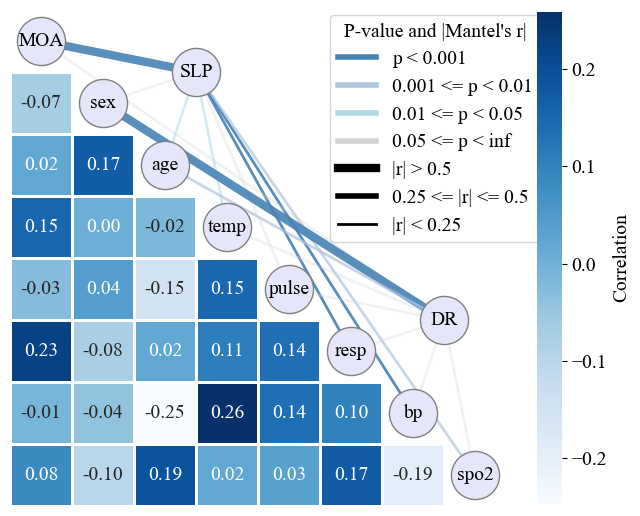

In [35]:
from matplotlib.lines import Line2D


fontsize = 14
plt.rc("font", family='Times New Roman', size=fontsize)

# 6. 计算相关矩阵，并仅保留下三角矩阵，掩盖对角线
corr_matrix = env_data.corr()

# 将对角线部分（相关系数为1）设置为NaN，使其不显示
np.fill_diagonal(corr_matrix.values, np.nan)

# 掩盖上三角部分
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 仅掩盖上三角部分

# 7. 使用Seaborn绘制仅显示下三角的相关性矩阵热力图，保留对角线但为空白
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', 
            ax=ax, square=True, cbar=True, fmt=".2f", mask=mask,
            linewidths=1, linecolor='white', annot_kws={"size": fontsize}, 
            cbar_kws={"shrink": 0.8, "label": "Correlation"})


# 10. 提取边的权重、颜色和透明度
weights = [G[u][v]['weight'] for u, v in G.edges()]
colors = [G[u][v]['color'] for u, v in G.edges()]
alphas = [G[u][v]['alpha'] for u, v in G.edges()]

# 11. 定义节点位置
# 将矩阵内部的节点放置在对角线上
pos = {}
for i, node in enumerate(p_values_df.index):
    # 将节点放置在对角线上，即(i, i)处，对应热力图的网格坐标
    pos[node] = (i + 0.5, i + 0.5)

# 定义spec01, spec02, spec03, spec04的位置，放在指定的坐标点
spec_positions = {
    'SLP': (3, 1), 
    'DR': (7, 5),}
# 更新spec节点的坐标
pos.update(spec_positions)

# 12. 绘制节点
nx.draw_networkx_nodes(G,
    pos,
    node_color='lavender',  # 节点颜色
    node_size=1200,  # 节点大小
    edgecolors='grey',  # 节点边框颜色
    ax=ax)

# 13. 绘制边，包含透明度
for i, (u, v) in enumerate(G.edges()):
    nx.draw_networkx_edges(G,
        pos,
        edgelist=[(u, v)],  # 单独绘制每条边
        width=weights[i],  # 根据r值设置边的宽度
        edge_color=colors[i],  # 边的颜色
        alpha=alphas[i],  # 边的透明度
        ax=ax,
        connectionstyle='arc3,rad=0.2')  # 弧形边的连接样式

# 14. 添加文本标注
for node, (x, y) in pos.items():
    ax.text(x, y, node, fontsize=fontsize, ha='center', va='center')

# 15. 添加线条颜色和宽度图例
# P-value 图例元素
p_value_legend_elements = [
    Line2D([0], [0], color=color, lw=4, label=f'{low} <= p < {high}' if low != 0 else f'p < {high}')
    for (low, high), (color, alpha) in color_alpha_map.items()]


# Mantel's r 图例元素
r_value_legend_elements = [
    Line2D([0], [0], color='black', lw=6, label='|r| > 0.5'),
    Line2D([0], [0], color='black', lw=4, label='0.25 <= |r| <= 0.5'), 
    Line2D([0], [0], color='black', lw=2, label='|r| < 0.25')]
combined_legend_elements = p_value_legend_elements + r_value_legend_elements
# 创建一个综合的图例
ax.legend(handles=combined_legend_elements, 
          loc='upper left', 
          bbox_to_anchor=(0.625, 1.01), 
          title="P-value and |Mantel's r|")
# plt.rc("font", family='MicroSoft YaHei', weight="bold")
plt.savefig("./result/heatmap.svg", format='svg', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
def CasualWeighted(vs_data, labels):
    num_classes = labels.unique().numel()  # 标签类别数
    n_feat = vs_data.shape[1]  # 生命体征特征数
    prob_matrix = torch.zeros_like(vs_data, dtype=torch.float)
    for label in range(num_classes):
        vs_subset = vs_data[labels == label]
        for col in range(n_feat):
            unique_vals, counts = vs_subset[:, col].unique(return_counts=True)
            probs = counts.float() / vs_subset.shape[0]
            for val, prob in zip(unique_vals, probs):
                mask = (vs_data[:, col] == val) & (labels == label)
                prob_matrix[mask, col] = prob
    return vs_data * prob_matrix

def SFD_encoder(vs):
    batch_size, _ = vs.shape
    indices = vs.nonzero(as_tuple=True)[1].view(batch_size, -1)
    num_indices = indices.shape[1]
    distance_matrix = torch.zeros((batch_size, num_indices, num_indices), dtype=torch.float32)
    for idx in range(batch_size):
        feature_indices = indices[idx].float().view(-1, 1)
        dist_matrix = torch.cdist(feature_indices, feature_indices, p=1)
        distance_matrix[idx] = dist_matrix
    tri_indices = torch.triu_indices(distance_matrix.size(1), distance_matrix.size(2), offset=1)
    return distance_matrix[:, tri_indices[0], tri_indices[1]]

VitalSign = SFD_encoder(vs) #vs: vital signs
vs_feat_cw = CasualWeighted(VitalSign, batch['Level'])

In [7]:
import torch

def compute_conditional_mean_probs(train_vs_data, train_labels):
    """
    计算每个类别内，各标签针对每个特征的条件概率的平均值。
    
    Args:
        train_vs_data (torch.Tensor): 训练数据 (N, F)，N为样本数，F为特征数。
        train_labels (torch.Tensor): 训练数据的标签 (N,)。
    
    Returns:
        torch.Tensor: 各类别内特征的条件概率平均值 (C, F)，C为标签类别数，F为特征数。
    """
    num_classes = train_labels.unique().numel()  # 标签类别数
    n_feat = train_vs_data.shape[1]  # 特征数
    mean_conditional_probs = torch.zeros((num_classes, n_feat), dtype=torch.float)
    
    for label in range(num_classes):
        vs_subset = train_vs_data[train_labels == label]  # 当前标签的样本
        n_samples_label = vs_subset.shape[0]
        
        for col in range(n_feat):
            unique_vals, counts = vs_subset[:, col].unique(return_counts=True)
            # 计算条件概率
            probs = counts.float() / n_samples_label
            # 条件概率的平均值
            mean_conditional_probs[label, col] = probs.mean() if len(probs) > 0 else 0.0
    
    return mean_conditional_probs

def apply_conditional_mean_probs(test_vs_data, mean_conditional_probs, test_labels):
    """
    在验证/测试阶段应用训练阶段的条件概率平均值权重。
    
    Args:
        test_vs_data (torch.Tensor): 测试数据 (N, F)，N为样本数，F为特征数。
        mean_conditional_probs (torch.Tensor): 条件概率平均值权重 (C, F)。
        test_labels (torch.Tensor): 测试数据的标签 (N,)。
    
    Returns:
        torch.Tensor: 加权后的测试数据 (N, F)。
    """
    weighted_vs_data = torch.zeros_like(test_vs_data)
    for label in range(mean_conditional_probs.shape[0]):
        mask = test_labels == label
        weighted_vs_data[mask] = test_vs_data[mask] * mean_conditional_probs[label]
    return weighted_vs_data

# 示例数据
train_vs_data = torch.tensor([
    [1, 5, 6, 9, 2],
    [1, 2, 5, 7, 1],
    [2, 3, 5, 7, 1],
    [2, 5, 7, 9, 1],
    [1, 4, 6, 7, 2]
], dtype=torch.float)

train_labels = torch.tensor([0, 1, 1, 0, 0], dtype=torch.long)  # 示例标签

test_vs_data = torch.tensor([
    [1, 3, 5, 7, 2],
    [2, 4, 6, 8, 1]
], dtype=torch.float)

test_labels = torch.tensor([0, 1], dtype=torch.long)  # 测试数据的标签

# 训练阶段：计算条件概率的平均值
mean_conditional_probs = compute_conditional_mean_probs(train_vs_data, train_labels)

# 验证/测试阶段：应用权重
weighted_test_vs_data = apply_conditional_mean_probs(test_vs_data, mean_conditional_probs, test_labels)

print("训练阶段计算的条件概率平均值：")
print(mean_conditional_probs)
print("\n加权后的测试数据：")
print(weighted_test_vs_data)


训练阶段计算的条件概率平均值：
tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 1.0000, 1.0000, 1.0000]])

加权后的测试数据：
tensor([[0.5000, 1.5000, 2.5000, 3.5000, 1.0000],
        [1.0000, 2.0000, 6.0000, 8.0000, 1.0000]])


In [8]:
import torch

# 训练阶段：计算加权矩阵
def CasualWeighted_train(vs_data, labels):
    num_classes = labels.unique().numel()  # 标签类别数
    n_feat = vs_data.shape[1]  # 生命体征特征数
    prob_matrix = torch.zeros_like(vs_data, dtype=torch.float)
    
    for label in range(num_classes):
        vs_subset = vs_data[labels == label]  # 仅使用训练数据中的标签
        for col in range(n_feat):
            unique_vals, counts = vs_subset[:, col].unique(return_counts=True)
            probs = counts.float() / vs_subset.shape[0]
            for val, prob in zip(unique_vals, probs):
                mask = (vs_data[:, col] == val) & (labels == label)
                prob_matrix[mask, col] = prob

    return prob_matrix

# 测试阶段：应用训练阶段计算的加权矩阵
def CasualWeighted_test(vs_data, prob_matrix_train):
    # 确保测试数据的维度与训练数据一致
    prob_matrix_test = torch.zeros_like(vs_data, dtype=torch.float)
    
    n_feat = vs_data.shape[1]
    
    for col in range(n_feat):
        unique_vals = vs_data[:, col].unique()
        
        for val in unique_vals:
            # 查找训练集中特征值对应的概率
            prob = prob_matrix_train[vs_data[:, col] == val, col].mean()  # 计算训练集中的概率
            mask = vs_data[:, col] == val
            prob_matrix_test[mask, col] = prob

    return vs_data * prob_matrix_test


# 示例：训练和测试流程
# 假设训练数据和标签
vs_data_train = torch.tensor([[1, 5, 6, 9, 2], [1, 2, 5, 7, 1], [2, 3, 5, 7, 1]])
labels_train = torch.tensor([0, 1, 0])

# 训练阶段：计算加权矩阵
prob_matrix_train = CasualWeighted_train(vs_data_train, labels_train)

# 假设测试数据
vs_data_test = torch.tensor([[1, 5, 6, 9, 2], [2, 3, 5, 7, 1]])

# 测试阶段：应用训练阶段计算的加权矩阵
vs_data_test_weighted = CasualWeighted_test(vs_data_test, prob_matrix_train)

print(vs_data_test_weighted)


IndexError: The shape of the mask [2] at index 0 does not match the shape of the indexed tensor [3] at index 0

In [ ]:
[rank0]:   File "/home/user/anaconda3/envs/Text_Image/lib/python3.10/site-packages/torch/distributed/c10d_logger.py", line 83, in wrapper
[rank0]:     return func(*args, **kwargs)
[rank0]:   File "/home/user/anaconda3/envs/Text_Image/lib/python3.10/site-packages/torch/distributed/c10d_logger.py", line 97, in wrapper
[rank0]:     func_return = func(*args, **kwargs)
[rank0]:   File "/home/user/anaconda3/envs/Text_Image/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py", line 1454, in init_process_group
[rank0]:     raise ValueError("trying to initialize the default process group twice!")
[rank0]: ValueError: trying to initialize the default process group twice!

In [ ]:
# 1. CUHK-PEDES
bash shell/data_process.sh
# or
python data_process.py --dataset_name "CUHK-PEDES" --dataset_root_dir [CUHK-PEDES DATASET DIRECTORY]

# 2. ICFG-PEDES
bash shell/data_process.sh
# or
python data_process.py --dataset_name "ICFG-PEDES" --dataset_root_dir "F:\DataSet\CrossModalRetrieval\Image_Text\ICFG-PEDES"

# 3. RSTPReid
bash shell/data_process.sh
# or
python data_process.py --dataset_name "RSTPReid" --dataset_root_dir [RSTPReid DATASET DIRECTORY]

In [ ]:
python -m torch.distributed.run --nproc_per_node=4 --rdzv_endpoint=127.0.0.1:29501 Retrieval.py --config configs/PS_icfg_pedes.yaml --output_dir output/icfg-pedes/train --checkpoint "./checkpoint" --eval_mAP

In [ ]:
python  Retrieval.py --config configs/PS_icfg_pedes.yaml --output_dir output/icfg-pedes/train --checkpoint "./checkpoint" --eval_mAP

In [9]:
import torch.distributed as dist
dist.is_available()

True